# Original toy drifting example from the authors

This recreates the original **uncondtional drifting** notebook:
- sample toy datasets (checkerboard + swiss roll)
- visualize drift vectors for random generated points
- train a small MLP generator with the drifting loss

Paper reference: https://arxiv.org/abs/2602.04770


In [1]:
import os, sys


for k in ("JAX_PLATFORMS", "JAX_PLATFORM_NAME"):
    os.environ.pop(k, None)

if sys.platform == "darwin":
    os.environ["JAX_PLATFORMS"] = "cpu"


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax
import flax.linen as nn

from driftax.datasets import sample_checkerboard, sample_swiss_roll
from driftax.drift import compute_V, drifting_loss_features

print("JAX devices:", jax.devices())


JAX devices: [CpuDevice(id=0)]


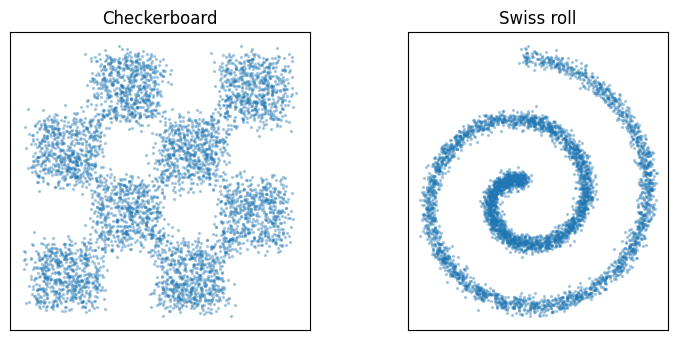

In [3]:
# Quick look at toy datasets
key = jax.random.PRNGKey(42)
k1, k2 = jax.random.split(key)

cb = np.array(sample_checkerboard(k1, 5000, noise=0.05))
sr = np.array(sample_swiss_roll(k2, 5000, noise=0.03))

fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
for ax, (name, pts) in zip(axes, [("Checkerboard", cb), ("Swiss roll", sr)]):
    ax.scatter(pts[:, 0], pts[:, 1], s=2, alpha=0.3)
    ax.set_aspect("equal")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(name)
plt.tight_layout()
plt.show()


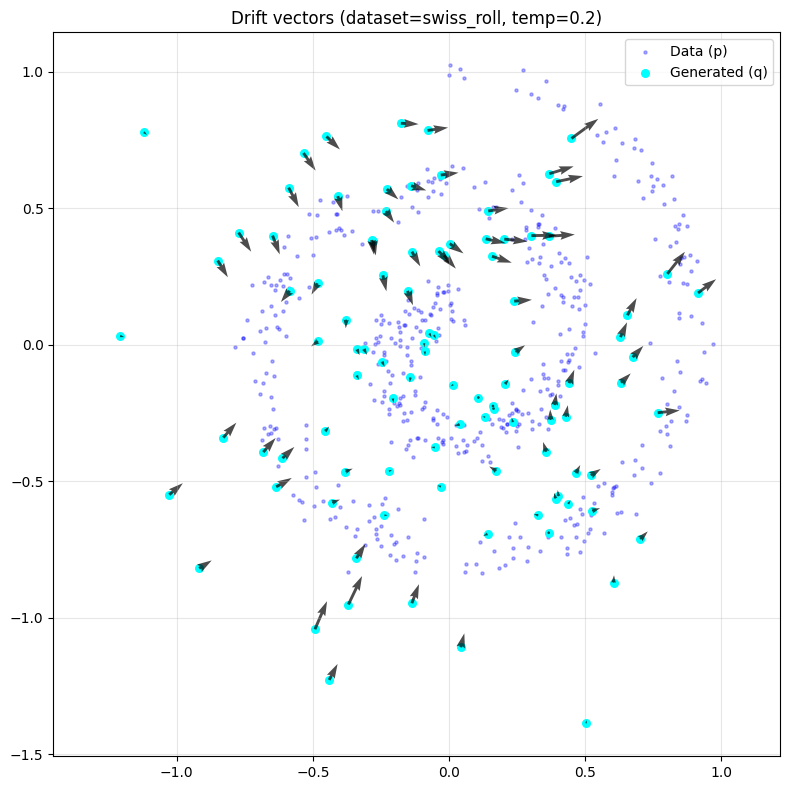

In [5]:
# Drift vector visualization 

def visualize_drift(dataset="checkerboard", temp=0.2, seed=42):
    sampler = sample_checkerboard if dataset.lower().startswith("check") else sample_swiss_roll

    key = jax.random.PRNGKey(seed)
    key, k_gen, k_pos = jax.random.split(key, 3)

    gen = 0.5 * jax.random.normal(k_gen, (100, 2), dtype=jnp.float32)
    pos = sampler(k_pos, 500, noise=0.05)

    V = compute_V(gen, pos, gen, temp=temp)

    gen_np = np.array(gen)
    pos_np = np.array(pos)
    V_np = np.array(V)

    plt.figure(figsize=(8, 8))
    plt.scatter(pos_np[:, 0], pos_np[:, 1], s=5, alpha=0.3, c="blue", label="Data (p)")
    plt.scatter(gen_np[:, 0], gen_np[:, 1], s=30, c="cyan", label="Generated (q)")
    plt.quiver(gen_np[:, 0], gen_np[:, 1], V_np[:, 0], V_np[:, 1],
               scale=3, color="black", alpha=0.7, width=0.004)
    plt.legend()
    plt.title(f"Drift vectors (dataset={dataset}, temp={temp})")
    plt.axis("equal")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

visualize_drift("swiss_roll", temp=0.2)


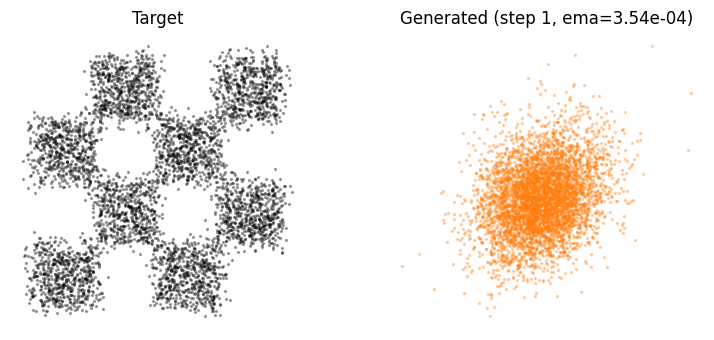

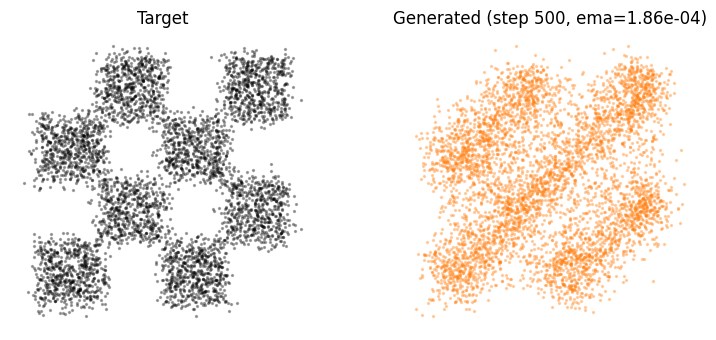

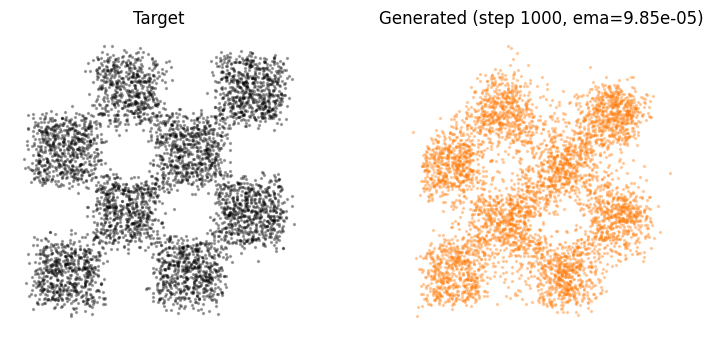

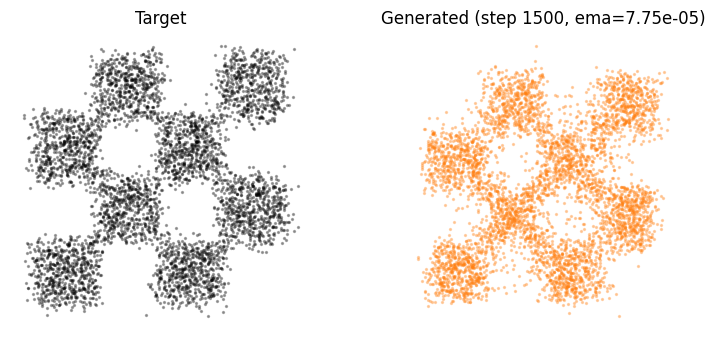

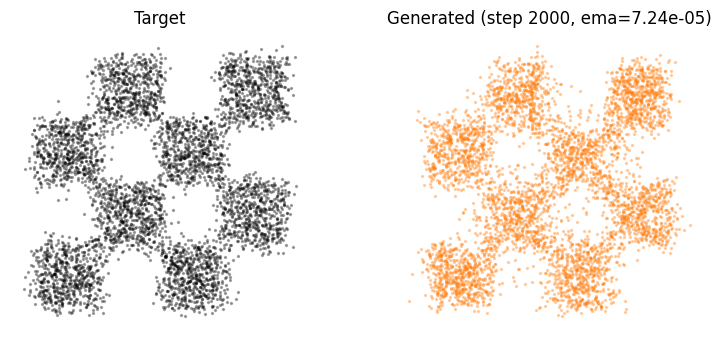

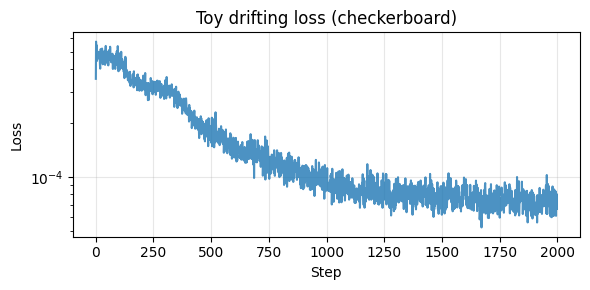

In [6]:
# Train a toy MLP generator with drifting loss: MSE(gen, stopgrad(gen + V))

class MLP(nn.Module):
    in_dim: int = 32
    hidden: int = 256
    out_dim: int = 2

    @nn.compact
    def __call__(self, z: jnp.ndarray) -> jnp.ndarray:
        x = nn.Dense(self.hidden)(z); x = nn.silu(x)
        x = nn.Dense(self.hidden)(x); x = nn.silu(x)
        x = nn.Dense(self.hidden)(x); x = nn.silu(x)
        x = nn.Dense(self.out_dim)(x)
        return x

dataset = "checkerboard"
sampler = sample_checkerboard if dataset.lower().startswith("check") else sample_swiss_roll

steps = 2000
data_batch_size = 2048
gen_batch_size = 2048
lr = 1e-3
temp = 0.05
z_dim = 32
plot_every = 500
noise = 0.05

key = jax.random.PRNGKey(42)
key, k_init = jax.random.split(key)

model = MLP(in_dim=z_dim, hidden=256, out_dim=2)
params = model.init(k_init, jnp.zeros((1, z_dim), dtype=jnp.float32))

opt = optax.adam(lr)
opt_state = opt.init(params)

@jax.jit
def step_fn(params, opt_state, key):
    key, k_pos, k_z = jax.random.split(key, 3)
    pos = sampler(k_pos, data_batch_size, noise=noise)
    z = jax.random.normal(k_z, (gen_batch_size, z_dim), dtype=jnp.float32)
    gen = model.apply(params, z)

    loss = drifting_loss_features(
        x_feat=gen,
        pos_feat=pos,
        temps=(temp,),
        neg_feat=gen,
        feature_normalize=False,
        drift_normalize=False,
    )
    grads = jax.grad(lambda p: drifting_loss_features(
        x_feat=model.apply(p, z),
        pos_feat=pos,
        temps=(temp,),
        neg_feat=model.apply(p, z),
        feature_normalize=False,
        drift_normalize=False,
    ))(params)

    updates, opt_state2 = opt.update(grads, opt_state, params)
    params2 = optax.apply_updates(params, updates)
    return params2, opt_state2, key, loss

loss_hist = []
ema = None

for s in range(1, steps + 1):
    params, opt_state, key, loss = step_fn(params, opt_state, key)
    loss_val = float(loss)
    loss_hist.append(loss_val)
    ema = loss_val if ema is None else 0.96 * ema + 0.04 * loss_val

    if s == 1 or (plot_every and s % plot_every == 0):
        key, k_gt, k_vis = jax.random.split(key, 3)
        gt = np.array(sampler(k_gt, 5000, noise=noise))
        z = jax.random.normal(k_vis, (5000, z_dim), dtype=jnp.float32)
        vis = np.array(model.apply(params, z))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))
        ax1.scatter(gt[:, 0], gt[:, 1], s=2, alpha=0.3, c="black")
        ax1.set_title("Target"); ax1.set_aspect("equal"); ax1.axis("off")
        ax2.scatter(vis[:, 0], vis[:, 1], s=2, alpha=0.3, c="tab:orange")
        ax2.set_title(f"Generated (step {s}, ema={ema:.2e})"); ax2.set_aspect("equal"); ax2.axis("off")
        plt.tight_layout()
        plt.show()

loss_hist = np.asarray(loss_hist, dtype=np.float32)
plt.figure(figsize=(6, 3))
plt.plot(loss_hist, alpha=0.8)
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.xlabel("Step"); plt.ylabel("Loss")
plt.title(f"Toy drifting loss ({dataset})")
plt.tight_layout()
plt.show()
